# test Facebook Prohpet library

Test prediction model based on Facebook [Prophet](https://facebook.github.io/prophet) library

In [1]:
import datetime
import calendar
import pprint
import json
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4

# Load project

In [2]:
project_folder = '../../datasets/radon-small/'
with open(project_folder + 'project.json', 'r') as file:
    project = json.load(file)
pprint.pprint(project)
print('Flow1')
flow = pd.read_csv(project_folder + 'flow1.csv', parse_dates=['time'])
flow = flow.set_index('time')['flow'].fillna(0)
flow = flow.resample('5T').pad()
flow.head()

{'end-date': '2017-11-09',
 'flows': ['flow1'],
 'name': 'radon-small',
 'rainfalls': [],
 'split-date': '2016-11-09',
 'start-date': '2013-10-01'}
Flow1


time
2013-09-09 10:50:00     2.805
2013-09-09 10:55:00     2.796
2013-09-09 11:00:00     2.791
2013-09-09 11:05:00    46.680
2013-09-09 11:10:00    48.030
Freq: 5T, Name: flow, dtype: float64

## Helper functions

Helper functions for building training and test sets and calculating score

In [3]:
class PredictionModel:
    
    def update(self, data_points):
        pass
        
    def predict(self, prediction_day):
        pass

    
def mae(y_hat, y):
    """
    Calculate Mean Absolute Error 
    This metric is better here since serries have quite big outliers
    """
    return np.sum(np.absolute(y_hat-y))/y.shape[0]


def split_data(split_day):
    """Get all data up to given day"""
    return flow[:split_day]


def evaluate_model(model, start_day):
    """
    Evaluate model on all days starting from split_day.
    Returns 90th percentile error as model score
    """
    last_day = pd.Timestamp(project['end-date'])
    split_day = start_day
    costs = []
    data = split_data(split_day)
    model.fit(data)
    while split_day < last_day:
        next_day = split_day + pd.Timedelta(1, 'D')
        y = flow[next_day: next_day+pd.Timedelta('1439 min')]
        cost = mae(model.predict(next_day), y)
        costs.append(cost)
        split_day = next_day
    return np.percentile(costs, 90), costs


split_data(pd.Timestamp('2016-11-10')).tail()

time
2016-11-09 23:40:00    77.021540
2016-11-09 23:45:00    76.518930
2016-11-09 23:50:00    76.294914
2016-11-09 23:55:00    74.822395
2016-11-10 00:00:00    73.598236
Freq: 5T, Name: flow, dtype: float64

# Prophet

In [7]:
class ProphetModel(PredictionModel):
    
    def __init__(self):
        self.prophet = Prophet()
    
    def fit(self, xs):
        df = xs.to_frame().reset_index()
        df = df.rename(columns={'time': 'ds', 'flow': 'y'})
        self.prophet.fit(df)
        
    def predict(self, day):
        df = flow[day: day+pd.Timedelta('1439 min')].to_frame().reset_index()
        df = df.rename(columns={'time': 'ds', 'flow': 'y'})
        return self.prophet.predict(df)['yhat'].values

    
model = ProphetModel()
score, costs = evaluate_model(model, pd.Timestamp('2016-11-11'))
print('ProphetModel score: {:.2f}'.format(score))
print('Score for the split day: {:.2f}'.format(costs[0]))

ProphetModel score: 44.88
Score for the split day: 5.06


This was easy case. Mean model has score: 5.01 on the split day, and score for the whole year: 9.61

Lest now check more difficult day, when the flow is different from what we can expect:

In [8]:
model = ProphetModel()
score, costs = evaluate_model(model, pd.Timestamp('2017-05-01'))
print('Score for the split day: {:.2f}'.format(costs[0]))

Score for the split day: 15.11


Mean model for this day has score: 16.67

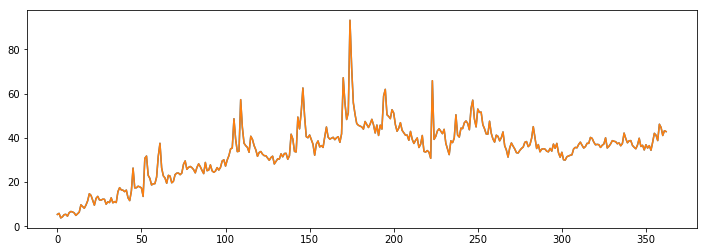

In [55]:
plt.plot(costs)
plt.show()